# Analysing the dark day over San Francisco (Sep 9 2020)

In [4]:
import openaq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aqtools import aqutils as u
api = openaq.OpenAQ()

On Sep 9, 2020, San Francisco experienced a day where the skyturned [orange](https://www.newyorker.com/culture/video-dept/the-day-the-san-francisco-sky-turned-orange)

## Loading in the Data

In [27]:
status, resp = api.measurements(city = 'San Francisco-Oakland-Fremont', location='San Francisco', parameter=['co','pm25'], date_from = '2020-04-01', date_to = '2021-01-01', sort = 'asc', limit = 10000)
r = resp['results']
df = pd.DataFrame(data=r)

dates = []
for date in df['date'].values:
    local_date = date['local']
    d = u.cleaning_date(local_date)
    dates.append(d)
df['date'] = pd.to_datetime(dates)
df = df.reindex(columns=['parameter', 'value', 'date'])
df = df.pivot(index='date', columns='parameter', values='value')
df

parameter,co,pm25
date,,
2020-03-31 17:00:00,0.26,2.0
2020-03-31 18:00:00,0.25,2.0
2020-03-31 19:00:00,0.25,4.0
2020-03-31 20:00:00,0.24,1.0
2020-03-31 21:00:00,0.24,-2.0
...,...,...
2020-11-25 13:00:00,0.26,4.0
2020-11-25 15:00:00,0.23,4.0
2020-11-25 16:00:00,0.25,2.0


We load in data from 2020, before and after the incident, so that the spike is clear.
In descriptions of the event, it has been described to be caused by the combination of fog and smoke caused by wildfires. Since fog is not very quantifiable in these analyses, we focus on variables commonly associated with wildfires, like PM2.5 suspended particulate matter, as well as carbon monoxide production.

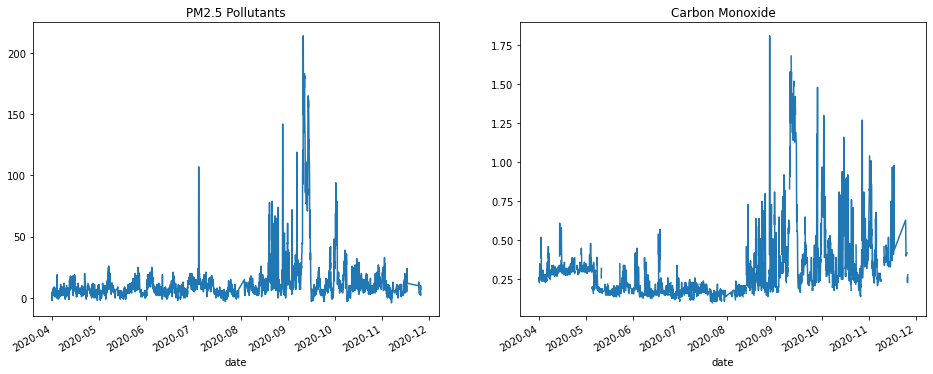

In [28]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

df['pm25'].plot(ax = ax[0], title = 'PM2.5 Pollutants')
df['co'].plot(ax = ax[1], title = 'Carbon Monoxide');

We see above that there is a clear spike in PM2.5 pollutants concentration around September, and there is also a less prominent spike in the Carbon Monoxide concentration plot. This is to be expected given that in 2020 there were many wildfires which would have all caused spikes.

## Zooming in on the period around September (ASO- August September October)

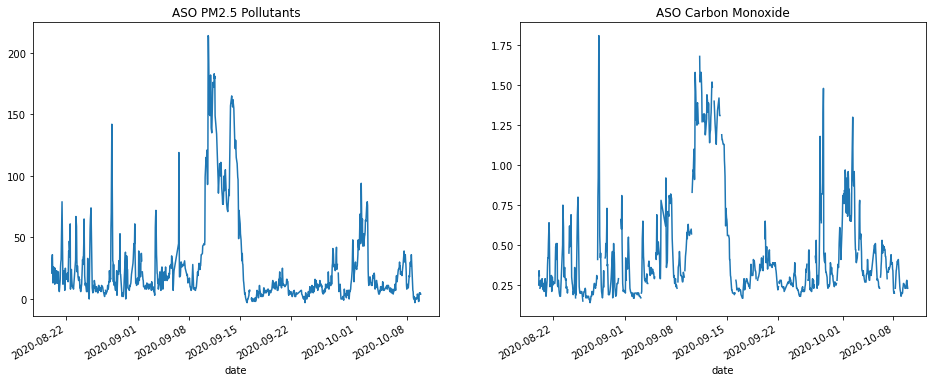

In [35]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
#df_around_september = df.query('date.dt.month == 9 or date.dt.month == 8 or date.dt.month == 10')
df_around_september = df.query('date > "2020-08-20" and date < "2020-10-10"')
df_around_september['pm25'].plot(ax = ax[0], title = 'ASO PM2.5 Pollutants')
df_around_september['co'].plot(ax = ax[1], title = 'ASO Carbon Monoxide');

In [54]:
print('Maximum CO concentration found at ', df_around_september['co'].idxmax())

Maximum CO concentration found at  2020-08-28 08:00:00


In [55]:
print('Maximum PM2.5 concentration found at ', df_around_september['pm25'].idxmax())

Maximum PM2.5 concentration found at  2020-09-10 15:00:00


In terms of the PM2.5 graph, while there are other spikes, it seems like there is a clear spike around the orange skies event in question. However, for the CO graph, there are stronger spikes elsewhere. An interesting thing to note is that the CO concentration around the time of the event seems to be consistently high (barring missing values). This would suggest the use of a moving average (maybe a few hours) rather than the values themselves.

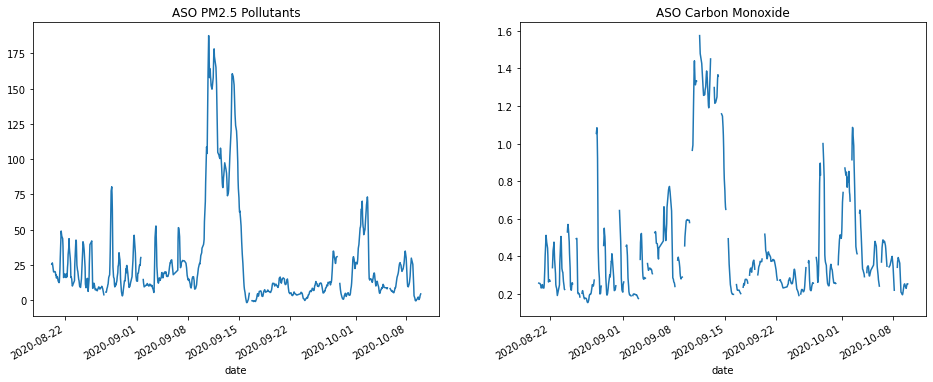

In [57]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
df_around_september_roll = df_around_september.rolling(window = 5, center = False).mean()
df_around_september_roll['pm25'].plot(ax = ax[0], title = 'ASO PM2.5 Pollutants')
df_around_september_roll['co'].plot(ax = ax[1], title = 'ASO Carbon Monoxide');

This would seem to confirm the finding that about 5 days of accumulated PM2.5 and CO concentration would maybe cause the orange skies. Let's confirm by finding the max days and verifying that they are indeed September 9 or close to it.

In [60]:
print('Maximum CO concentration found at ', df_around_september_roll['co'].idxmax())

Maximum CO concentration found at  2020-09-11 12:00:00


In [61]:
print('Maximum PM2.5 concentration found at ', df_around_september_roll['pm25'].idxmax())

Maximum PM2.5 concentration found at  2020-09-10 19:00:00


We see that the maximum concentration of both PM2.5 and CO occurs around Sep 10-11 which is around the time orange skies were prevalent in San Francisco

## Are PM2.5 and CO related?

We look at some basic analysis to determine whether there is a correlation between PM2.5 and CO concentrations.

There are many NA missing values in the CO column while PM2.5 column seems full. Can we use PM2.5 to infer the CO value?

In [84]:
print(str(df['pm25'].isna().mean() * 100) + " is percent missing values in PM2.5 column")
print(str(df['co'].isna().mean() * 100) + " is percent missing values in CO column")

0.610798924993892 is percent missing values in PM2.5 column
4.764231614952358 is percent missing values in CO column


In [85]:
import numpy as np
df_no_na = df.dropna()
m, b = np.polyfit(df_no_na['pm25'], df_no_na['co'], 1)

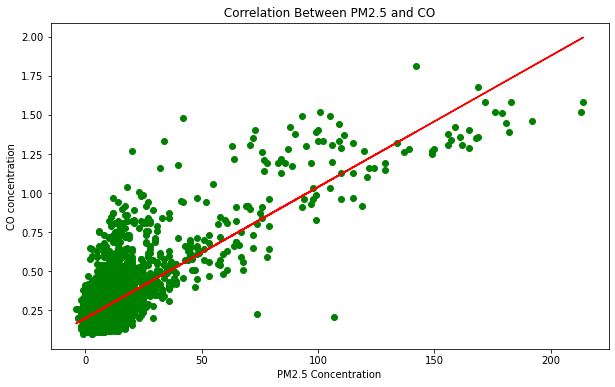

In [102]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.scatter(df['pm25'], df['co'], color = 'green')
ax.plot(df['pm25'], (m * df['pm25']) + b, color = 'red')
ax.set_ylabel("CO concentration")
ax.set_xlabel("PM2.5 Concentration")
ax.set_title(" Correlation Between PM2.5 and CO ");

The line seems to fit the data reasonably well. We may use this to infer the missing values.

In [103]:
df['co_modelled'] = m * df['pm25'] + b
df['co_inferred'] = df['co'].fillna(df['co_modelled'])

<AxesSubplot:title={'center':'CO Inferred'}, xlabel='date'>

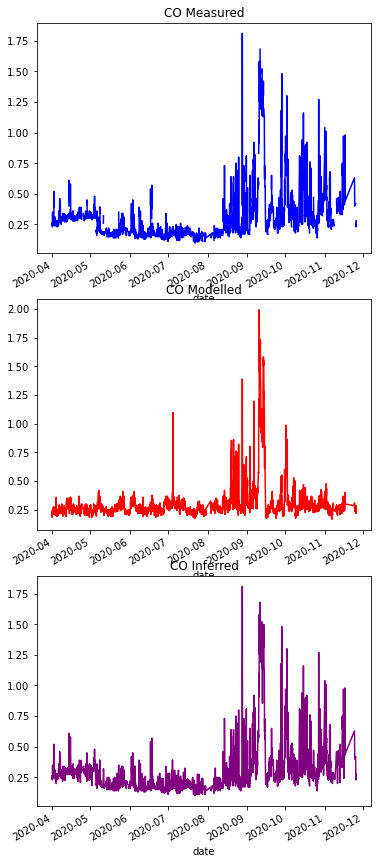

In [109]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(6,16))
df['co'].plot(ax = ax[0], title = 'CO Measured', color = 'blue')
df['co_modelled'].plot(ax = ax[1], title = 'CO Modelled', color = 'red');
df['co_inferred'].plot(ax = ax[2], title = 'CO Inferred', color = 'purple')

## Back to the Dark Day

Does the analysis from before still yield the dark day, with the new inferred values, and how does it compare to linearly interpolated values?

In [116]:
df_around_september = df.query('date > "2020-08-20" and date < "2020-10-10"')
df_around_september['co_interpolated'] = df_around_september['co'].interpolate()

/tmp/ipykernel_2573/2895539279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_around_september['co_interpolated'] = df_around_september['co'].interpolate()


In [117]:
df_around_september_roll = df_around_september.rolling(window = 5, center = False).mean()

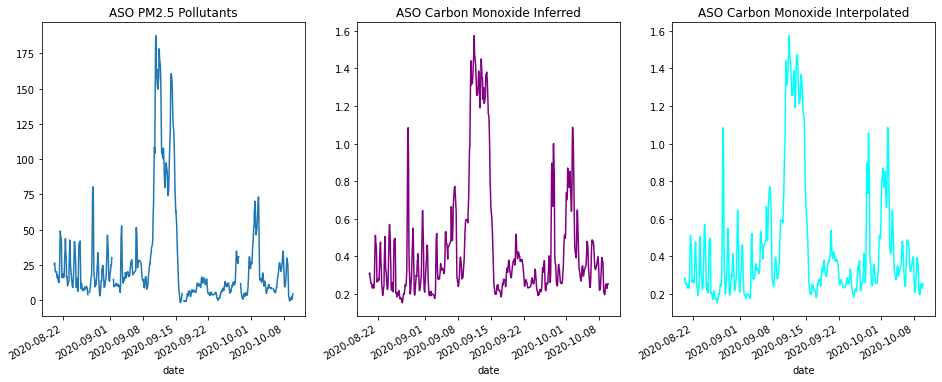

In [118]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
df_around_september_roll['pm25'].plot(ax = ax[0], title = 'ASO PM2.5 Pollutants')
df_around_september_roll['co_inferred'].plot(ax = ax[1], title = 'ASO Carbon Monoxide Inferred', color = 'purple')
df_around_september_roll['co_interpolated'].plot(ax = ax[2], title = 'ASO Carbon Monoxide Interpolated', color = 'cyan');

In [119]:
print('Maximum CO concentration found at ', df_around_september_roll['co'].idxmax())
print('Maximum CO Inferred concentration found at ', df_around_september_roll['co_inferred'].idxmax())
print('Maximum CO Interpolated concentration found at ', df_around_september_roll['co_interpolated'].idxmax())

Maximum CO concentration found at  2020-09-11 12:00:00
Maximum CO Inferred concentration found at  2020-09-11 12:00:00
Maximum CO Interpolated concentration found at  2020-09-11 12:00:00


In [120]:
print('Maximum PM2.5 concentration found at ', df_around_september_roll['pm25'].idxmax())

Maximum PM2.5 concentration found at  2020-09-10 19:00:00


No significant difference in the results was found. We can conclude that inferring CO from PM2.5 in this case was not worse than linear interpolation. Also, we have confirmed the results from before, with the spike in PM2.5 and CO coinciding with the Orange skies over San Francisco.